#### Run this notebook as a sanity check for your implementation

### Creating search pipelines for two different ranking strategies.

* Pipeline 1: Initial ranking by BM25 with re-ranking by LambdaMART (Cross-encoder feature enabled)

* Pipeline 2: Initial ranking by Bi-Encoder vector ranker with re-ranking by LambdaMART (Cross-encoder feature enabled)

The corpus for the main index is augmented by doc2query queries

In [1]:
import csv
from collections import Counter, defaultdict
from tqdm import tqdm
import json
import jsonlines
import numpy as np
import gzip
import os
import pickle
import pandas as pd

# your modules are imported here
from indexing import Indexer, IndexType, BasicInvertedIndex
from document_preprocessor import RegexTokenizer, Doc2QueryAugmenter
from ranker import Ranker, BM25, CrossEncoderScorer
from vector_ranker import VectorRanker
from network_features import NetworkFeatures
from l2r import L2RFeatureExtractor, L2RRanker
from relevance import run_relevance_tests

/home/zim/.virtualenvs/SI650/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# change these to point to actual file paths
DRIVE_PATH = '../data/'
CACHE_PATH = '../cache/'
STOPWORD_PATH = DRIVE_PATH + 'stopwords.txt'
DATASET_PATH = DRIVE_PATH + 'wikipedia_200k_dataset.jsonl.gz'
EDGELIST_PATH = DRIVE_PATH + 'edgelist.csv'
NETWORK_STATS_PATH = DRIVE_PATH + 'network_stats.csv'
DOC2QUERY_PATH = DRIVE_PATH + 'doc2query.csv'
MAIN_INDEX = 'main_index_augmented'
TITLE_INDEX = 'title_index'
RELEVANCE_TRAIN_DATA = DRIVE_PATH + 'hw3_relevance.train.csv'
ENCODED_DOCUMENT_EMBEDDINGS_NPY_DATA = DRIVE_PATH + \
    'wiki-200k-vecs.msmarco-MiniLM-L12-cos-v5.npy'
RELEVANCE_TEST_DATA = DRIVE_PATH + 'hw3_relevance.test.csv'

In [3]:
# Load in the stopwords

stopwords = set()
with open(STOPWORD_PATH, 'r', encoding='utf-8') as file:
    for stopword in file:
        stopwords.add(stopword.strip())
f'Stopwords collected {len(stopwords)}'

'Stopwords collected 543'

In [4]:
# Get the list of categories for each page (either compute it or load the pre-computed list)
file_path = CACHE_PATH + 'docid_to_categories.pkl'
if not os.path.exists(file_path):
    docid_to_categories = {}
    with gzip.open(DATASET_PATH, 'rt') as file:
        for line in tqdm(file, total=200_000):
            document = json.loads(line)
            docid_to_categories[document['docid']] = document['categories']
    pickle.dump(docid_to_categories, open(file_path, 'wb'))
else:
    docid_to_categories = pickle.load(open(file_path, 'rb'))
f'Document categories collected'

'Document categories collected'

In [5]:
# Get or pre-compute the list of categories at least the minimum number of times (specified in the homework)
category_counts = Counter()
for cats in tqdm(docid_to_categories.values(), total=len(docid_to_categories)):
    for c in cats:
        category_counts[c] += 1
recognized_categories = set(
    [cat for cat, count in category_counts.items() if count >= 1000])
print("saw %d categories" % len(recognized_categories))

file_path = CACHE_PATH + 'doc_category_info.pkl'
if not os.path.exists(file_path):
    # Map each document to the smallert set of categories that occur frequently
    doc_category_info = {}
    for docid, cats in tqdm(docid_to_categories.items(), total=len(docid_to_categories)):
        valid_cats = [c for c in cats if c in recognized_categories]
        doc_category_info[docid] = valid_cats
    pickle.dump(doc_category_info, open(file_path, 'wb'))
else:
    doc_category_info = pickle.load(open(file_path, 'rb'))

100%|██████████| 200000/200000 [00:00<00:00, 578401.83it/s]


saw 118 categories


In [6]:
network_features = {}
# Get or load the network statistics for the Wikipedia link network

if not os.path.exists(NETWORK_STATS_PATH):
    nf = NetworkFeatures()
    print('loading network')
    graph = nf.load_network(EDGELIST_PATH, total_edges=92650947)
    print('getting stats')
    net_feats_df = nf.get_all_network_statistics(graph)
    graph = None
    print('Saving')
    net_feats_df.to_csv(NETWORK_STATS_PATH, index=False)

    print("converting to dict format")
    network_features = defaultdict(dict)
    for i, row in tqdm(net_feats_df.iterrows(), total=len(net_feats_df)):
        for col in ['pagerank', 'hub_score', 'authority_score']:
            network_features[row['docid']][col] = row[col]
    net_feats_df = None
else:
    with open(NETWORK_STATS_PATH, 'r', encoding='utf-8') as file:
        for idx, line in enumerate(file):
            if idx == 0:
                continue
            else:
                # the indexes may change depending on your CSV
                splits = line.strip().split(',')
                network_features[int(splits[0])] = {
                    'pagerank': float(splits[1]),
                    'authority_score': float(splits[2]),
                    'hub_score': float(splits[3])
                }
f'Network stats collection {len(network_features)}'

'Network stats collection 999841'

In [7]:
d2q = Doc2QueryAugmenter()
text = 'The Evil Within is a survival horror video game developed by Tango Gameworks and published by Bethesda Softworks. The game was directed by Resident Evil series creator Shinji Mikami and was released worldwide in October 2014 for PlayStation 3, PlayStation 4, Windows, Xbox 360, and Xbox One.'
d2q.get_queries(text, 5)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['who is the creator of the evil within',
 'what is evil within?',
 'what is the evil within',
 'what game was the evil within released on',
 'when was the evil within released']

In [8]:
doc_augment_dict = defaultdict(lambda: [])
with open(DOC2QUERY_PATH, 'r', encoding='utf-8') as file:
    dataset = csv.reader(file)
    for idx, row in tqdm(enumerate(dataset), total=600_000):
        if idx == 0:
            continue
        doc_augment_dict[int(row[0])].append(row[2])

600001it [00:00, 719664.83it/s]                             


In [9]:
# Load or build Inverted Indices for the documents' main text and titles
#
# Estiamted times:
#    Document text token counting: 4 minutes
#    Document text indexing: 5 minutes
#    Title text indexing: 30 seconds
preprocessor = RegexTokenizer('\w+')

# Creating and saving the index

# main_index_path = CACHE_PATH + MAIN_INDEX
main_index = Indexer.create_index(
    IndexType.InvertedIndex, DATASET_PATH, preprocessor,
    stopwords, 50, doc_augment_dict=doc_augment_dict)
# main_index.save(main_index_path)

# title_index_path = CACHE_PATH + TITLE_INDEX
title_index = Indexer.create_index(
    IndexType.InvertedIndex, DATASET_PATH, preprocessor,
    stopwords, 2, text_key='title')
# title_index.save(title_index_path)


Indexing...


100%|██████████| 200000/200000 [02:45<00:00, 1207.13it/s]


Indexing...


100%|██████████| 200000/200000 [00:21<00:00, 9515.95it/s] 


In [10]:
with open(RELEVANCE_TRAIN_DATA, 'r') as file:
    data = csv.reader(file)
    train_queries = []
    train_docs = []
    for idx, row in tqdm(enumerate(data)):
        if idx == 0:
            continue
        if row[0] not in train_queries:
            train_queries.append(row[0])
        if row[2] not in train_docs:
            train_docs.append(row[2])

9605it [00:00, 55099.14it/s]


In [11]:
# create the raw text dictionary by going through the wiki dataset
# this dictionary should store only the first 500 characters of the raw documents text

file_path = CACHE_PATH + 'raw_text_dict_train.pkl'
if not os.path.exists(file_path):
    raw_text_dict = {}
    file = gzip.open(DATASET_PATH, 'rt')
    with jsonlines.Reader(file) as reader:
        for _ in tqdm(range(200_000)):
            try:
                data = reader.read()
                if str(data['docid']) in train_docs:
                    raw_text_dict[int(data['docid'])] = data['text'][:500]
            except EOFError:
                break
    pickle.dump(raw_text_dict, open(file_path, 'wb'))
else:
    raw_text_dict = pickle.load(open(file_path, 'rb'))

In [12]:
# Create the feature extractor. This will be used by both pipelines
cescorer = CrossEncoderScorer(raw_text_dict)
fe = L2RFeatureExtractor(main_index, title_index, doc_category_info,
                         preprocessor, stopwords, recognized_categories,
                         network_features, cescorer)

In [13]:
# Create an intial ranker for determining what to re-rank
# Use these with a L2RRanker and then train that L2RRanker model
#
# Estimated time (using 4 cores via n_jobs): 7 minutes

# An initial ranking with BM25 with reranking done by LambdaMART optimizing NDCG
bm25 = BM25(main_index)
ranker = Ranker(main_index, preprocessor, stopwords, bm25)

pipeline_1 = L2RRanker(main_index, title_index, preprocessor,
                       stopwords, ranker, fe)

pipeline_1.train(RELEVANCE_TRAIN_DATA)

# An initial ranking with VectorRanker with reranking done by LambdaMART optimizing NDCG
with open(ENCODED_DOCUMENT_EMBEDDINGS_NPY_DATA, 'rb') as file:
    encoded_docs = np.load(file)

vector_ranker = VectorRanker('sentence-transformers/msmarco-MiniLM-L12-cos-v5',
                             encoded_docs, list(main_index.document_metadata.keys()))

pipeline_2 = L2RRanker(main_index, title_index, preprocessor,
                       stopwords, vector_ranker, fe)

pipeline_2.train(RELEVANCE_TRAIN_DATA)

Loading training data...
Training model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2641
[LightGBM] [Info] Number of data points in the train set: 9604, number of used features: 123
Loading training data...
Training model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2641
[LightGBM] [Info] Number of data points in the train set: 9604, number of used features: 123


In [14]:
scores_ranker = run_relevance_tests(RELEVANCE_TEST_DATA, ranker)
print(f'BM25 scores: {scores_ranker}')
print("MAP: ", scores_ranker['map'])
print("NDCG: ", scores_ranker['ndcg'])

Running relevance tests...


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [01:37<00:00,  2.63s/it]

MAP:  [0.025, 0.05, 0.19285714285714287, 0, 0, 0.26, 0.01, 0, 0.02, 0, 0.11333333333333333, 0, 0, 0.0125, 0, 0, 0.03333333333333333, 0, 0.04857142857142857, 0, 0.16666666666666666, 0.11666666666666665, 0, 0, 0.06666666666666667, 0, 0, 0, 0, 0, 0, 0.05, 0, 0, 0, 0.15, 0]
NDCG:  [0.16720121225264192, 0.1912049197383063, 0.40771619304648515, 0.0, 0.0, 0.35738444023216115, 0.0586666388908508, 0.0, 0.13279625411320248, 0.0, 0.44115113246165355, 0.04541743105845887, 0.0, 0.0716120549175052, 0.0, 0.06617289012360779, 0.16326880032415683, 0.0, 0.24276828655853022, 0.0, 0.3293683421236114, 0.3403003929241778, 0.0613262049089608, 0.07242198498924948, 0.21928535165731325, 0.0, 0.0, 0.0, 0.054633798952207324, 0.0, 0.0, 0.2578062004518628, 0.0, 0.0, 0.17487644530347446, 0.3040695800485996, 0.13058065054168094]
BM25 scores: {'map': 0.03555662805662805, 'ndcg': 0.11594673528699186}
MAP:  0.03555662805662805
NDCG:  0.11594673528699186


In [15]:
scores_pp1 = run_relevance_tests(RELEVANCE_TEST_DATA, pipeline_1)
print(f'BM25 scores: {scores_pp1}')
print("MAP: ", scores_pp1['map'])
print("NDCG: ", scores_pp1['ndcg'])

Running relevance tests...


100%|██████████| 37/37 [02:46<00:00,  4.51s/it]

MAP:  [0, 0, 0.025, 0.01, 0.05, 0.3571428571428571, 0.014285714285714285, 0, 0.02, 0, 0.0665079365079365, 0, 0, 0, 0, 0.075, 0, 0, 0, 0, 0.1, 0, 0, 0, 0.05, 0, 0, 0.1, 0.014285714285714285, 0, 0, 0.1, 0, 0, 0, 0.1, 0.0125]
NDCG:  [0.15044598817525506, 0.024114774059504164, 0.12133927614758865, 0.057290000967676655, 0.32809409741206513, 0.587523106887649, 0.06941992066371505, 0.0, 0.13279625411320248, 0.0, 0.25797972850121437, 0.0, 0.0, 0.0, 0.0, 0.4450994304378661, 0.0, 0.0, 0.0, 0.04462046518914338, 0.21888665798006005, 0.0, 0.04492063315887466, 0.0, 0.20342085232311144, 0.02138681585816852, 0.0, 0.19031326377064925, 0.07531155140665356, 0.0, 0.0, 0.2578062004518628, 0.0, 0.0, 0.453308352082741, 0.20271305336573306, 0.05075020367217313]
BM25 scores: {'map': 0.029587087087087086, 'ndcg': 0.10642001693580831}
MAP:  0.029587087087087086
NDCG:  0.10642001693580831


In [16]:
scores_pp2 = run_relevance_tests(RELEVANCE_TEST_DATA, pipeline_2)
print(f'BM25 scores: {scores_pp2}')
print("MAP: ", scores_pp2['map'])
print("NDCG: ", scores_pp2['ndcg'])

Running relevance tests...


100%|██████████| 37/37 [03:55<00:00,  6.36s/it]

MAP:  [0, 0, 0, 0, 0.1, 0.275, 0.0125, 0, 0.02, 0, 0.01111111111111111, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0.08333333333333333, 0, 0, 0, 0.1, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0.1, 0]
NDCG:  [0.05709397913119477, 0.0, 0.0, 0.0, 0.35152534067883506, 0.4377205066724933, 0.06496211865470962, 0.0, 0.14843011901892328, 0.0, 0.11492845531283281, 0.0, 0.0, 0.0, 0.0, 0.31689265655728094, 0.0, 0.0, 0.0, 0.0, 0.30356357608583323, 0.0, 0.0, 0.0, 0.20342085232311144, 0.0, 0.0, 0.19031326377064925, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37983770989879656, 0.20271305336573306, 0.03806265275412985]
BM25 scores: {'map': 0.02437687687687688, 'ndcg': 0.07593146714120333}
MAP:  0.02437687687687688
NDCG:  0.07593146714120333


In [22]:
ranker_map = [0.025, 0.05, 0.19285714285714287, 0, 0, 0.26, 0.01, 0, 0.02, 0, 0.11333333333333333, 0, 0, 0.0125, 0, 0, 0.03333333333333333, 0, 0.04857142857142857, 0, 0.16666666666666666, 0.11666666666666665, 0, 0, 0.06666666666666667, 0, 0, 0, 0, 0, 0, 0.05, 0, 0, 0, 0.15, 0]
ranker_ndcg = [0.16720121225264192, 0.1912049197383063, 0.40771619304648515, 0.0, 0.0, 0.35738444023216115, 0.0586666388908508, 0.0, 0.13279625411320248, 0.0, 0.44115113246165355, 0.04541743105845887, 0.0, 0.0716120549175052, 0.0, 0.06617289012360779, 0.16326880032415683, 0.0, 0.24276828655853022, 0.0, 0.3293683421236114, 0.3403003929241778, 0.0613262049089608, 0.07242198498924948, 0.21928535165731325, 0.0, 0.0, 0.0, 0.054633798952207324, 0.0, 0.0, 0.2578062004518628, 0.0, 0.0, 0.17487644530347446, 0.3040695800485996, 0.13058065054168094]
pp1_map = [0, 0, 0.025, 0.01, 0.05, 0.3571428571428571, 0.014285714285714285, 0, 0.02, 0, 0.0665079365079365, 0, 0, 0, 0, 0.075, 0, 0, 0, 0, 0.1, 0, 0, 0, 0.05, 0, 0, 0.1, 0.014285714285714285, 0, 0, 0.1, 0, 0, 0, 0.1, 0.0125]
pp1_ndcg = [0.15044598817525506, 0.024114774059504164, 0.12133927614758865, 0.057290000967676655, 0.32809409741206513, 0.587523106887649, 0.06941992066371505, 0.0, 0.13279625411320248, 0.0, 0.25797972850121437, 0.0, 0.0, 0.0, 0.0, 0.4450994304378661, 0.0, 0.0, 0.0, 0.04462046518914338, 0.21888665798006005, 0.0, 0.04492063315887466, 0.0, 0.20342085232311144, 0.02138681585816852, 0.0, 0.19031326377064925, 0.07531155140665356, 0.0, 0.0, 0.2578062004518628, 0.0, 0.0, 0.453308352082741, 0.20271305336573306, 0.05075020367217313]
pp2_map = [0, 0, 0, 0, 0.1, 0.275, 0.0125, 0, 0.02, 0, 0.01111111111111111, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0.08333333333333333, 0, 0, 0, 0.1, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0.1, 0]
pp2_ndcg = [0.05709397913119477, 0.0, 0.0, 0.0, 0.35152534067883506, 0.4377205066724933, 0.06496211865470962, 0.0, 0.14843011901892328, 0.0, 0.11492845531283281, 0.0, 0.0, 0.0, 0.0, 0.31689265655728094, 0.0, 0.0, 0.0, 0.0, 0.30356357608583323, 0.0, 0.0, 0.0, 0.20342085232311144, 0.0, 0.0, 0.19031326377064925, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37983770989879656, 0.20271305336573306, 0.03806265275412985]

In [23]:
df_data = []
for data in ranker_map:
    df_data.append((data, 'BM25', 'MAP'))
for data in ranker_ndcg:
    df_data.append((data, 'BM25', 'NDCG'))
for data in pp1_map:
    df_data.append((data, 'BM25+l2r', 'MAP'))
for data in pp1_ndcg:
    df_data.append((data, 'BM25+l2r', 'NDCG'))
for data in pp2_map:
    df_data.append((data, 'Vector+l2r', 'MAP'))
for data in pp2_ndcg:
    df_data.append((data, 'Vector+l2r', 'NDCG'))

In [28]:
df = pd.DataFrame(df_data, columns=['score', 'model', 'metric'])

In [25]:
import seaborn as sns

Text(0.5, 1.0, 'MAP@10 and NDCG@10 across Queries')

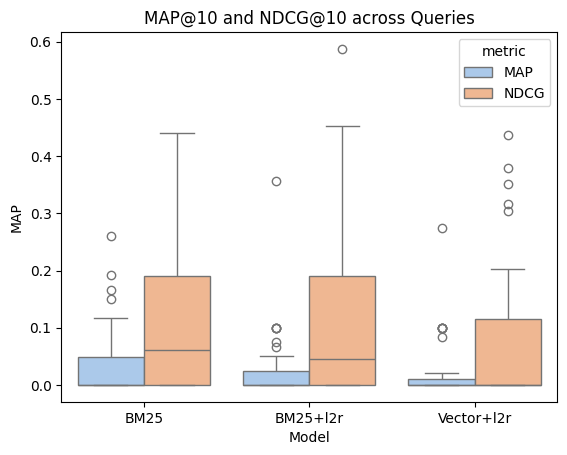

In [29]:
plot = sns.boxplot(data=df, x="model", y="score", hue="metric", palette="pastel")
plot.set_xlabel('Model')
plot.set_ylabel('MAP')
plot.set_title('MAP@10 and NDCG@10 across Queries')

In [17]:
import requests

def get_wiki_title(page_id:int):
    url = (
        'https://en.wikipedia.org/w/api.php'
        '?action=query'
        '&prop=info'
        '&inprop=subjectid'
        f'&pageids={page_id}' 
        '&format=json')
    json_response = requests.get(url).json()
    return json_response['query']['pages'][str(page_id)]['title']

After this point, students may have varying answers and observations depending on their implementation and their own features. So, your mileage may vary (YMMV)

### Example Query: 'How did the Mongols conquer China?'

This query should lead to pages about the different Mongolian invasions of China (there were multiple).

In [18]:
results = pipeline_1.query('How did the Mongols conquer China?')[:10]
[(get_wiki_title(result['docid']),result['score']) for result in results]

TypeError: tuple indices must be integers or slices, not str

In [ ]:
results = pipeline_2.query('How did the Mongols conquer China?')[:10]
[(get_wiki_title(result['docid']),result['score']) for result in results]

[('Mongol conquest of China', 0.15629720162936594),
 ('Proto-Mongols', 0.15511421967326222),
 ('Mongols in China', 0.14553224535134274),
 ('Mongols', 0.14553224535134274),
 ('Foreign relations of imperial China', 0.12819452617017554),
 ('Mongol invasions and conquests', 0.0943725611209057),
 ('Mongol conquest of the Song dynasty', 0.0943725611209057),
 ('Mongol military tactics and organization', 0.0943725611209057),
 ('Mongol conquest of Western Xia', 0.0943725611209057),
 ('Mongol invasion of the Khwarazmian Empire', 0.0943725611209057)]

**The first result is pretty similar**

But the difference is in what lies after maybe the second rank. You would see that the vector ranker would provide better pages overall in the top ranks of the fetched document list (in our experience the vector ranker pipeline focused more on conquests by mongols rather than details about mongols themselves).

### Example of a query where both the pipelines perform badly

**top 10 video games** 

In [ ]:
results = pipeline_1.query('top 10 video games')[:10]
[(get_wiki_title(result['docid']),result['score']) for result in results]

[('Sports video game', 0.14553224535134274),
 ('2016 in video games', 0.1379328933058825),
 ('2013 in video games', 0.1379328933058825),
 ('Breakout (video game)', 0.11870755503749891),
 ('2010s in video games', 0.11432081795467411),
 ('Centipede (video game)', 0.11101319980279584),
 ('Tile-based video game', 0.11101319980279584),
 ('Night Driver (video game)', 0.11101319980279584),
 ('Battlezone (1980 video game)', 0.11101319980279584),
 ('Video games in the United States', 0.11059455510698667)]

In [ ]:
results = pipeline_2.query('top 10 video games')[:10]
[(get_wiki_title(result['docid']),result['score']) for result in results]

[('Sports video game', 0.14553224535134274),
 ('2016 in video games', 0.1379328933058825),
 ('2013 in video games', 0.1379328933058825),
 ('Breakout (video game)', 0.11870755503749891),
 ('2010s in video games', 0.11432081795467411),
 ('Centipede (video game)', 0.11101319980279584),
 ('Tile-based video game', 0.11101319980279584),
 ('Night Driver (video game)', 0.11101319980279584),
 ('Battlezone (1980 video game)', 0.11101319980279584),
 ('Video games in the United States', 0.11059455510698667)]

Looking at the results, it doesn't seem that the search engine does very well on this query. Why might that be? Could you think of ways to handle these types of queries? What about other queries where the search engine might just not be very good?